# Setup

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyswarms as ps
import glob
import os
import importlib
import matplotlib.animation as animation
import gzip
import scanpy as sc
# np.infty = np.inf

from scipy.io import mmread
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.functions import single_obj as fx
from functools import partial
from IPython.display import HTML

import src.pbmc_SI as SI
importlib.reload(SI)

<module 'src.pbmc_SI' from 'd:\\Luca\\Documents\\GitHub\\BDA-project\\notebooks\\src\\pbmc_SI.py'>

# Import data

In [163]:
# 1) Point this to wherever your Cell Ranger output lives:
data_dir = 'data/pbmc10k/filtered_feature_bc_matrix'  # Adjust the path as needed

# 2) Load the data directly into an AnnData object
adata = sc.read_10x_mtx(data_dir, var_names='gene_symbols', cache=True)

# Check the loaded data
print(adata)

AnnData object with n_obs × n_vars = 10985 × 36601
    var: 'gene_ids', 'feature_types'


In [164]:
# ----------------------------------------
# 1. Load PCA and t-SNE Projections
# ----------------------------------------
pca_df_downloaded = pd.read_csv("data/pbmc10k/analysis/pca/10_components/projection.csv")
data_pca_downloaded = pca_df_downloaded.drop(columns=["Barcode"]).values

tsne_df_downloaded = pd.read_csv("data/pbmc10k/analysis/tsne/2_components/projection.csv")
data_tsne_downloaded = tsne_df_downloaded.drop(columns=["Barcode"]).values

# ----------------------------------------
# 2. Load Each K-Means Clustering File
# ----------------------------------------
cluster_files_downloaded = sorted(glob.glob("data/pbmc10k/analysis/clustering/*_clusters/clusters.csv"))

In [165]:
print(pca_df_downloaded.shape)
pca_df_downloaded.head()

(10985, 11)


,Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,AAACCCAGTATATGGA-1,-26.557559,43.616249,-5.920331,-0.437746,-0.684416,-1.070254,7.733377,-3.695116,0.180773,-1.931261
1,AAACCCAGTATCGTAC-1,2.446631,12.503169,9.143050,9.718873,-12.255868,-10.613059,17.103341,-0.873115,-1.452727,4.053146
2,AAACCCAGTCGGTGAA-1,-17.492857,-3.720638,-4.075000,4.693626,-0.223228,-2.966088,2.342027,3.268955,-1.077013,-4.942833
3,AAACCCAGTTAGAAAC-1,33.200922,1.940326,2.890780,3.308408,1.351145,0.437567,-1.220305,6.342324,-0.523541,-0.669859
4,AAACCCAGTTATCTTC-1,-11.462730,15.112253,-44.266984,-10.708478,10.581556,0.123756,-9.832545,1.948709,-4.145212,13.472980


In [166]:
print(tsne_df_downloaded.shape)
tsne_df_downloaded.head()

(10985, 3)


,Barcode,TSNE-1,TSNE-2
0,AAACCCAGTATATGGA-1,-45.109948,-18.605584
1,AAACCCAGTATCGTAC-1,8.243309,15.607494
2,AAACCCAGTCGGTGAA-1,-10.061613,-10.863419
3,AAACCCAGTTAGAAAC-1,20.417582,-4.917668
4,AAACCCAGTTATCTTC-1,-32.346937,-27.573911


In [167]:
clusters_df_downloaded = pd.read_csv("data/pbmc10k/analysis/clustering/kmeans_10_clusters/clusters.csv")
print(clusters_df_downloaded.shape)
clusters_df_downloaded.head()

(10985, 2)


,Barcode,Cluster
0,AAACCCAGTATATGGA-1,8
1,AAACCCAGTATCGTAC-1,1
2,AAACCCAGTCGGTGAA-1,3
3,AAACCCAGTTAGAAAC-1,2
4,AAACCCAGTTATCTTC-1,6


# Preprocessing

In [168]:
# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

# Identify highly variable genes (HVGs)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# Scale the data
sc.pp.scale(adata, max_value=10)

In [169]:
# Perform PCA
sc.tl.pca(adata, n_comps=10)

# Extract PCA-transformed data
pca_matrix = adata.obsm['X_pca']
pca_df = pd.DataFrame(pca_matrix, columns=[f"PC-{i+1}" for i in range(pca_matrix.shape[1])])
pca_df['Barcode'] = adata.obs_names

data_pca = pca_df.drop(columns=["Barcode"]).values

# Check the PCA DataFrame
pca_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,Barcode
0,-5.264180,1.269203,-3.811302,-1.505262,-0.774979,-1.302922,-1.618244,6.658130,1.999632,-1.310858,AAACCCAGTATATGGA-1
1,7.987750,-1.355090,0.128707,-0.265718,-0.095506,2.077773,7.423269,-8.617816,-2.184615,-0.311731,AAACCCAGTATCGTAC-1
2,-6.611729,-3.484494,0.363346,-1.098992,-0.739995,-0.568005,-0.346813,1.224607,4.803514,1.857635,AAACCCAGTCGGTGAA-1
3,11.834274,-1.702797,0.214291,-0.631840,-0.501974,-0.342928,-2.750960,-1.616891,-0.088206,0.034305,AAACCCAGTTAGAAAC-1
4,-10.116819,-9.951206,11.812151,-2.171686,0.059328,-1.921455,-0.096183,1.430626,-2.343105,-4.206045,AAACCCAGTTATCTTC-1


In [170]:
# Check the cumulative explained variance
explained_variance = np.cumsum(adata.uns['pca']['variance_ratio'])
print(explained_variance)

# Find the number of components that explain 95% of the variance
n_comps = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_comps}")

[0.07585233 0.11354851 0.14195937 0.16029185 0.17464688 0.18619059
 0.19605532 0.2031844  0.20921117 0.21443407]
Number of components for 95% variance: 1


In [171]:
# Extract the first two dimensions of data_pca
data_pca_2d = data_pca[:, :2]

# Print the shape to confirm
print(f"Shape of data_pca_2d: {data_pca_2d.shape}")

Shape of data_pca_2d: (10985, 2)


# Clustering

## K-Means

In [172]:
# Run K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(data_pca_2d)

# Save the clustering results
clusters_df = pca_df[['Barcode', 'Cluster']]
clusters_df.head()

,Barcode,Cluster
0,AAACCCAGTATATGGA-1,2
1,AAACCCAGTATCGTAC-1,1
2,AAACCCAGTCGGTGAA-1,3
3,AAACCCAGTTAGAAAC-1,4
4,AAACCCAGTTATCTTC-1,7


... storing 'feature_types' as categorical


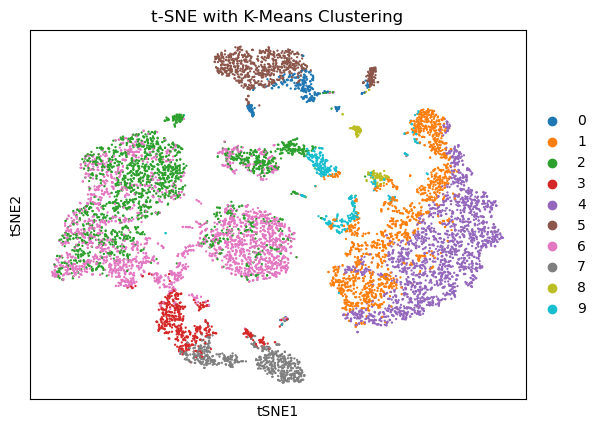

In [173]:
# Compute t-SNE
sc.tl.tsne(adata, n_pcs=10)

# Add K-Means cluster labels to adata for visualization
adata.obs['KMeans'] = pd.Categorical(pca_df['Cluster'].values)

# Plot t-SNE with K-Means clusters
sc.pl.tsne(adata, color='KMeans', title="t-SNE with K-Means Clustering")

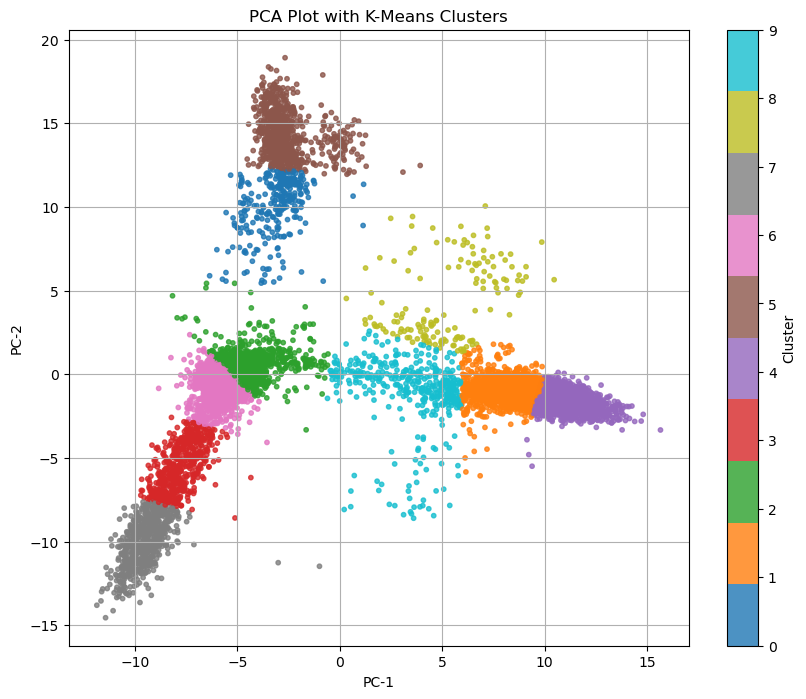

In [174]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    data_pca_2d[:, 0],  # PC-1
    data_pca_2d[:, 1],  # PC-2
    c=pca_df['Cluster'],  # Color by cluster
    cmap='tab10',  # Use a categorical colormap
    s=10,  # Marker size
    alpha=0.8  # Transparency
)
plt.colorbar(scatter, label="Cluster")
plt.title("PCA Plot with K-Means Clusters")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.grid(True)
plt.show()

In [175]:
results = pd.DataFrame(columns=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])
results.loc["K-Means"] = SI.calculate_clustering_scores(data_pca_2d, clusters_df["Cluster"])
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.402,0.836,52556.300781


## Swarm Intelligence

In [ ]:
n_clusters = 10
iters = 300

### PSO

In [ ]:
# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_pos_history, pso_cost_history, pso_best_centers_history = SI.run_pso(data_pca_2d, n_clusters, iters, n_particles = 30, record_history=True)
print("PSO run time: {:.2f} seconds".format(time.time() - start))

results.loc["PSO"] = SI.calculate_clustering_scores(data_pca, pso_labels)

2025-04-19 18:57:26,696 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.86e+4
2025-04-19 18:57:33,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 38629.62735847681, best pos: [-4.83555452  0.61771415  6.68074825  8.02030102 10.46222823 -0.46632197
 -0.35374879  3.21094688 -2.75600886 12.92144811 -0.94961364 -6.0651047
  6.92482851  0.80324835  5.85568711 -3.47036804  9.82593433 -1.78378647
 -8.54534083 -7.26692266]


PSO run time: 12.32 seconds


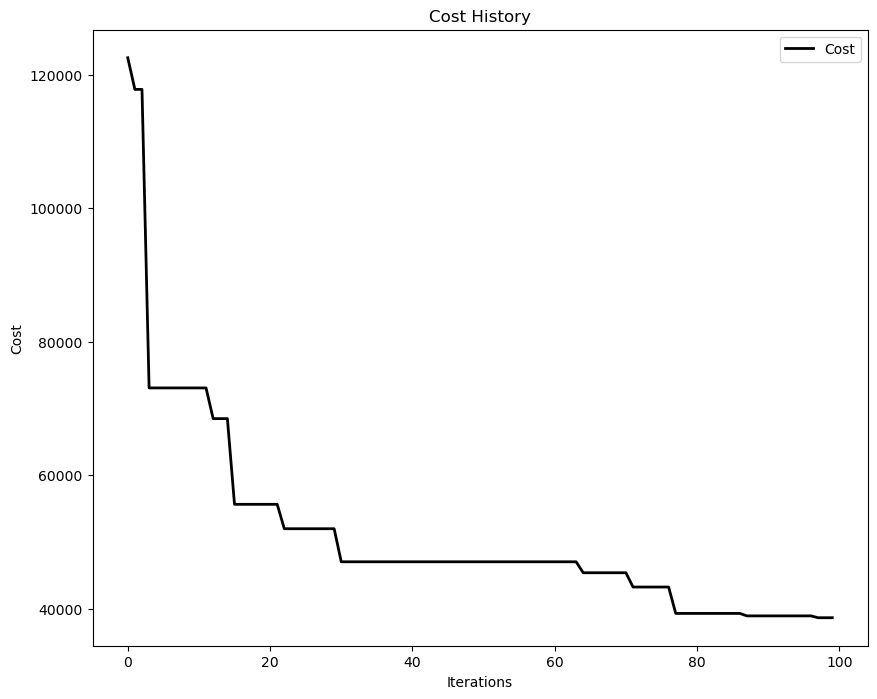

In [178]:
plot_cost_history(cost_history=pso_cost_history)
plt.show()

2025-04-19 18:57:41,196 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 18:57:41,197 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


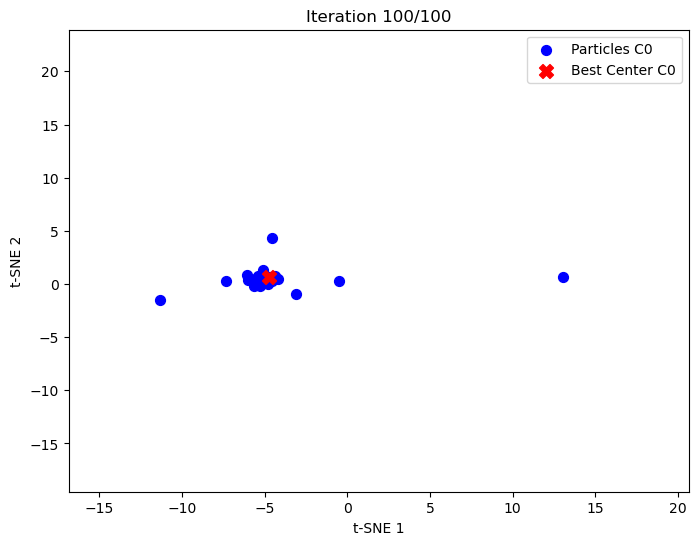

In [179]:
# To animate only cluster #0:
ani0 = SI.animate_best_center_history(data_pca_2d, pso_pos_history, pso_best_centers_history, center_idx=0)

# Save the animation as a GIF using imagemagick writer
ani0.save('../results/pbmc10k/pso/pso_animation_center0.gif', writer='imagemagick', fps=10)

### ABC

In [180]:
# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_history = SI.run_abc(data_pca_2d, n_clusters, iters, n_food_sources=30, limit=20, record_history=True)
print("ABC run time: {:.2f} seconds".format(time.time() - start))

results.loc["ABC"] = SI.calculate_clustering_scores(data_pca_2d, abc_labels)

ABC run time: 5.12 seconds


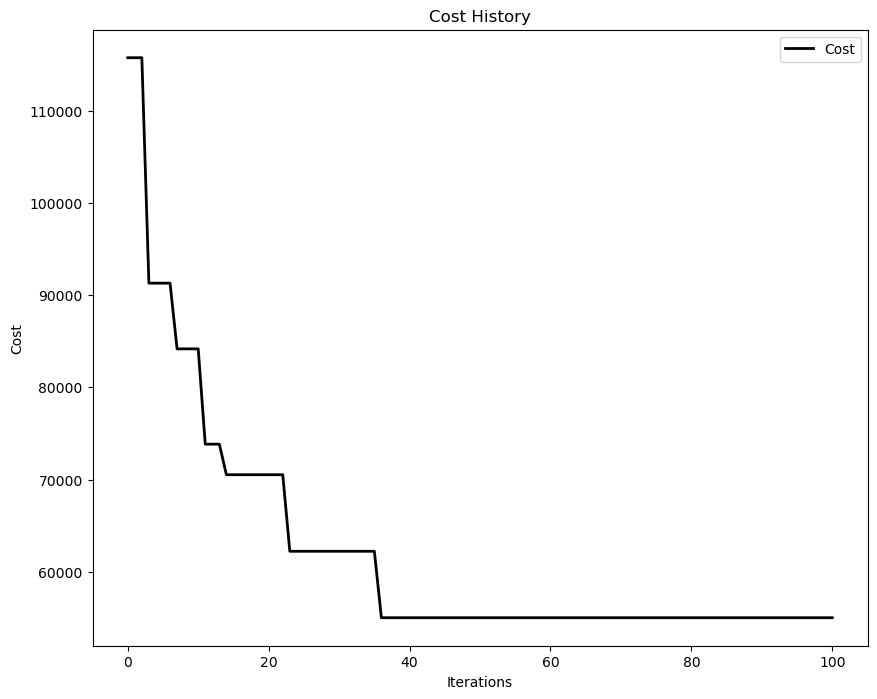

In [181]:
plot_cost_history(cost_history=abc_history["costs"])
plt.show()

2025-04-19 18:58:02,338 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 18:58:02,339 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


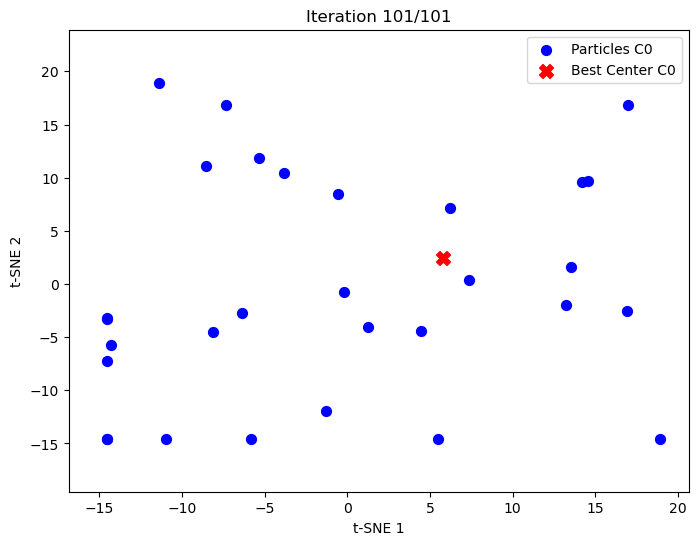

In [182]:
ani0 = SI.animate_best_center_history(data_pca_2d, abc_history["positions"], abc_history["best_centers"], center_idx=0)
ani0.save('../results/pbmc10k/abc/abc_animation_center0.gif', writer='imagemagick', fps=10)

### ACOR

In [183]:
# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_history = SI.run_acor(data_pca_2d, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True)
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

results.loc["ACOR"] = SI.calculate_clustering_scores(data_pca_2d, acor_labels)

ACOR run time: 6.29 seconds


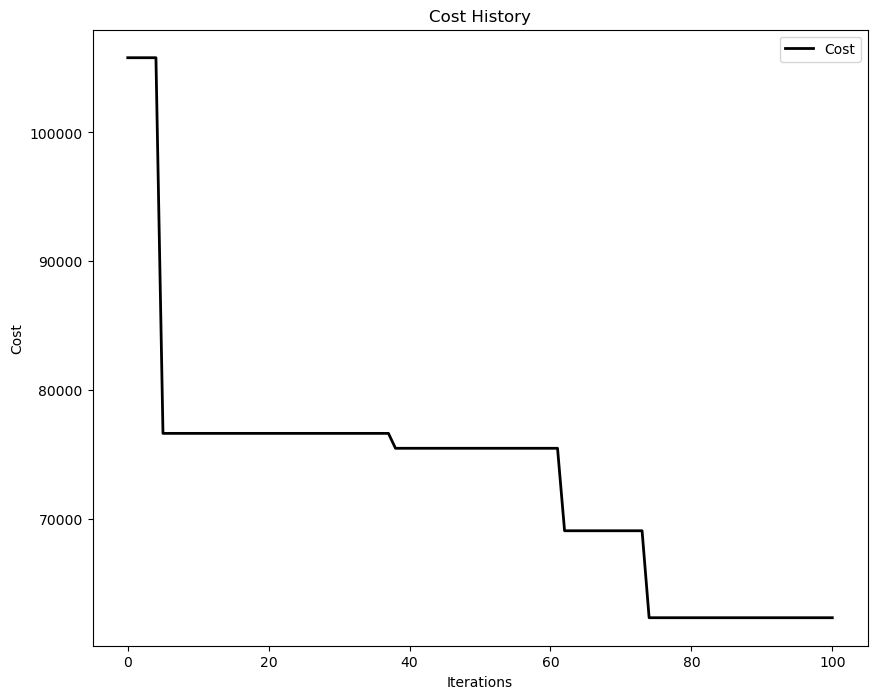

In [184]:
plot_cost_history(cost_history=acor_history["costs"])
plt.show()

2025-04-19 18:58:26,122 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2025-04-19 18:58:26,123 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


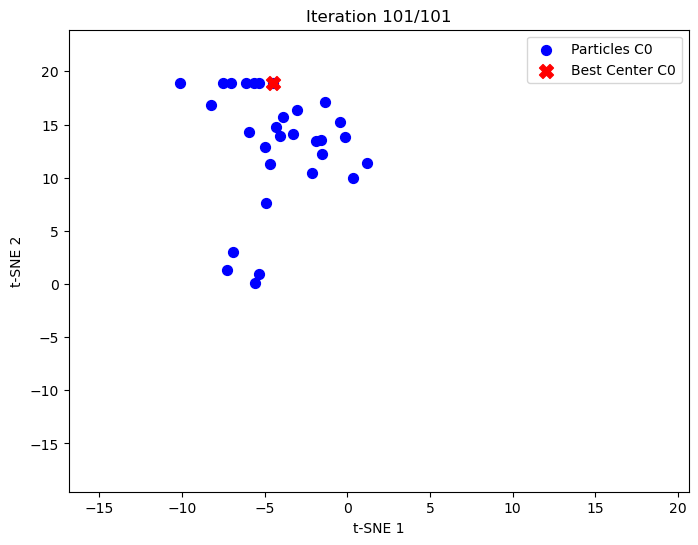

In [185]:
ani = SI.animate_best_center_history(data_pca_2d, acor_history["archives"], acor_history["best_centers"], center_idx=0)
ani.save('../results/pbmc10k/acor/acor_animation_center0.gif', writer='imagemagick', fps=10)

# Results

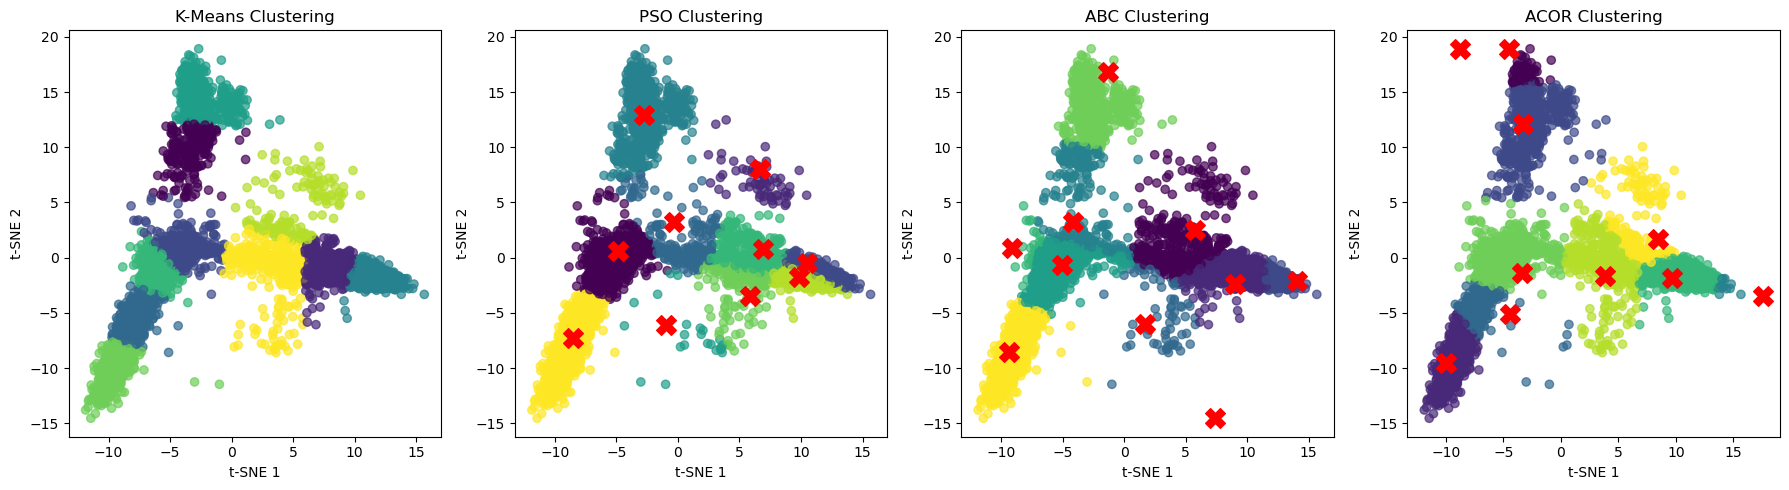

In [186]:
# -------------------------------
# 6. Visualization of Clustering Results
# -------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
SI.plot_clusters(data_pca_2d, clusters_df["Cluster"], title="K-Means Clustering")

plt.subplot(1, 4, 2)
SI.plot_clusters(data_pca_2d, pso_labels, title="PSO Clustering", centers=pso_centers)

plt.subplot(1, 4, 3)
SI.plot_clusters(data_pca_2d, abc_labels, title="ABC Clustering", centers=abc_centers)

plt.subplot(1, 4, 4)
SI.plot_clusters(data_pca_2d, acor_labels, title="ACOR Clustering", centers=acor_centers)

plt.tight_layout()
plt.show()

In [187]:
# Save clustering results to CSV files
results.to_csv("../results/pbmc10k/clustering_results.csv", index=True)
results.head()

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means,0.402,0.836,52556.300781
PSO,0.326,1.960,2104.399902
ABC,0.450,0.796,33981.300781
ACOR,0.524,0.770,38413.500000
